In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_train", 0.80, 12)

Found 2100 files belonging to 2 classes.
Using 420 files for training.
Using 1680 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (12, 4000)
Example label shape: (12,)


2024-03-25 20:46:21.859809: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-25 20:46:21.859831: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-25 20:46:21.859836: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-25 20:46:21.859866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-25 20:46:21.859885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

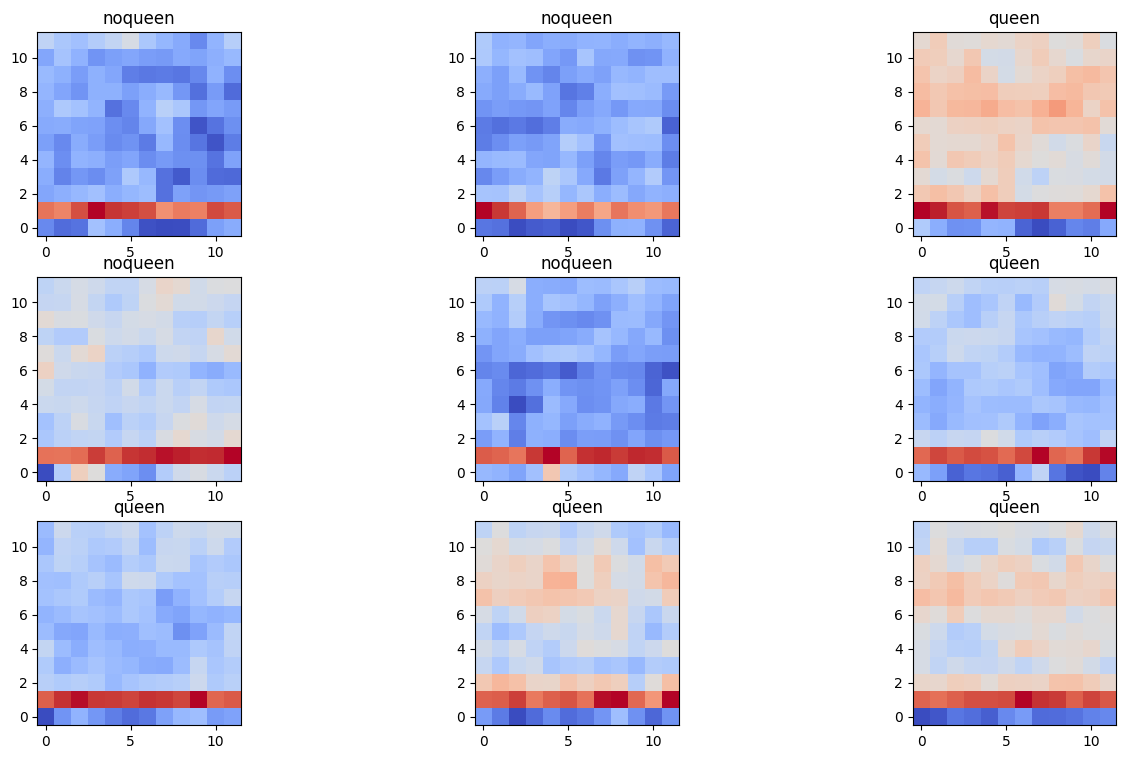

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-25 20:46:23.279944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-25 20:46:23.907676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


35/35 [==============================] - 2s 45ms/step - loss: 0.6402 - accuracy: 0.6476 - val_loss: 0.6498 - val_accuracy: 0.6685
Epoch 2/20
35/35 [==============================] - 1s 35ms/step - loss: 0.5262 - accuracy: 0.7548 - val_loss: 0.6215 - val_accuracy: 0.6524
Epoch 3/20
35/35 [==============================] - 1s 32ms/step - loss: 0.4891 - accuracy: 0.7762 - val_loss: 0.6753 - val_accuracy: 0.6744
Epoch 4/20
35/35 [==============================] - 1s 33ms/step - loss: 0.4537 - accuracy: 0.7905 - val_loss: 0.6078 - val_accuracy: 0.6786
Epoch 5/20
35/35 [==============================] - 1s 32ms/step - loss: 0.3921 - accuracy: 0.8286 - val_loss: 0.5834 - val_accuracy: 0.6756
Epoch 6/20
35/35 [==============================] - 1s 32ms/step - loss: 0.3558 - accuracy: 0.8381 - val_loss: 0.5742 - val_accuracy: 0.7137
Epoch 7/20
35/35 [==============================] - 1s 33ms/step - loss: 0.3386 - accuracy: 0.8429 - val_loss: 0.6357 - val_accuracy: 0.6679
Epoch 8/20
35/35 [======

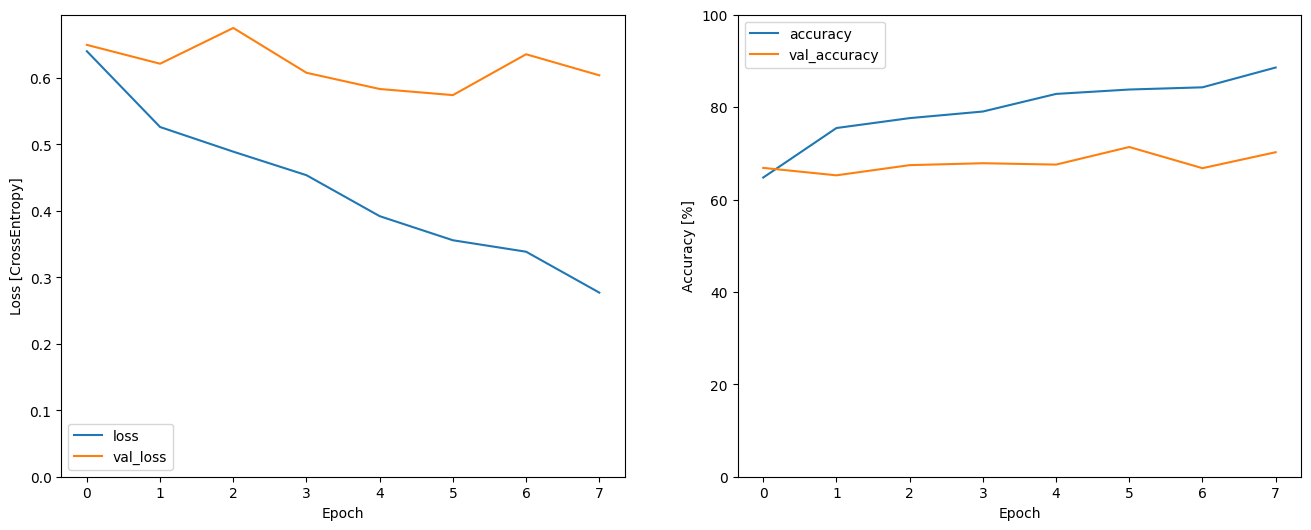

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
35/35 [==============================] - 1s 18ms/step - loss: 0.6968 - accuracy: 0.5333 - val_loss: 0.6862 - val_accuracy: 0.5387
Epoch 2/20
35/35 [==============================] - 1s 15ms/step - loss: 0.6592 - accuracy: 0.6714 - val_loss: 0.6701 - val_accuracy: 0.6185
Epoch 3/20
35/35 [==============================] - 1s 15ms/step - loss: 0.6356 - accuracy: 0.7095 - val_loss: 0.6585 - val_accuracy: 0.6387
Epoch 4/20
35/35 [==============================] - 1s 16ms/step - loss: 0.6193 - accuracy: 0.7190 - val_loss: 0.6494 - val_accuracy: 0.6452
Epoch 5/20
35/35 [==============================] - 1s 15ms/step - loss: 0.6030 - accuracy: 0.7286 - val_loss: 0.6424 - val_accuracy: 0.6536
Epoch 6/20
35/35 [==============================] - 1s 15ms/step - loss: 0.5908 - accuracy: 0.7214 - val_loss: 0.6357 - val_accuracy: 0.6571
Epoch 7/20
35/35 [==============================] - 1s 15ms/step - loss: 0.5810 - accuracy: 0.7238 - val_loss: 0.6332 - val_accuracy: 0.6601


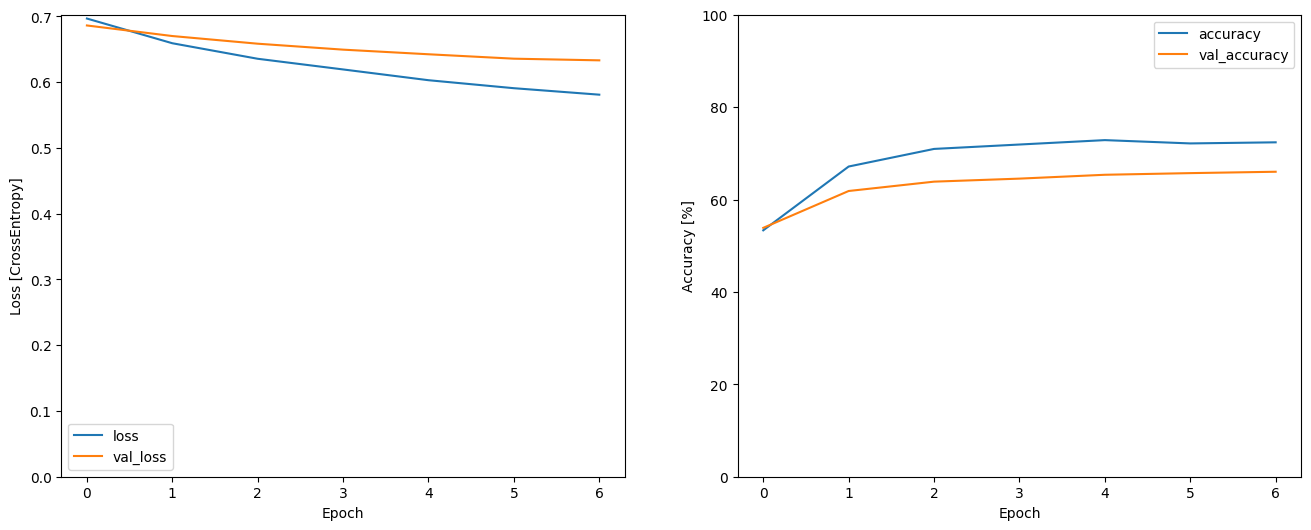

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


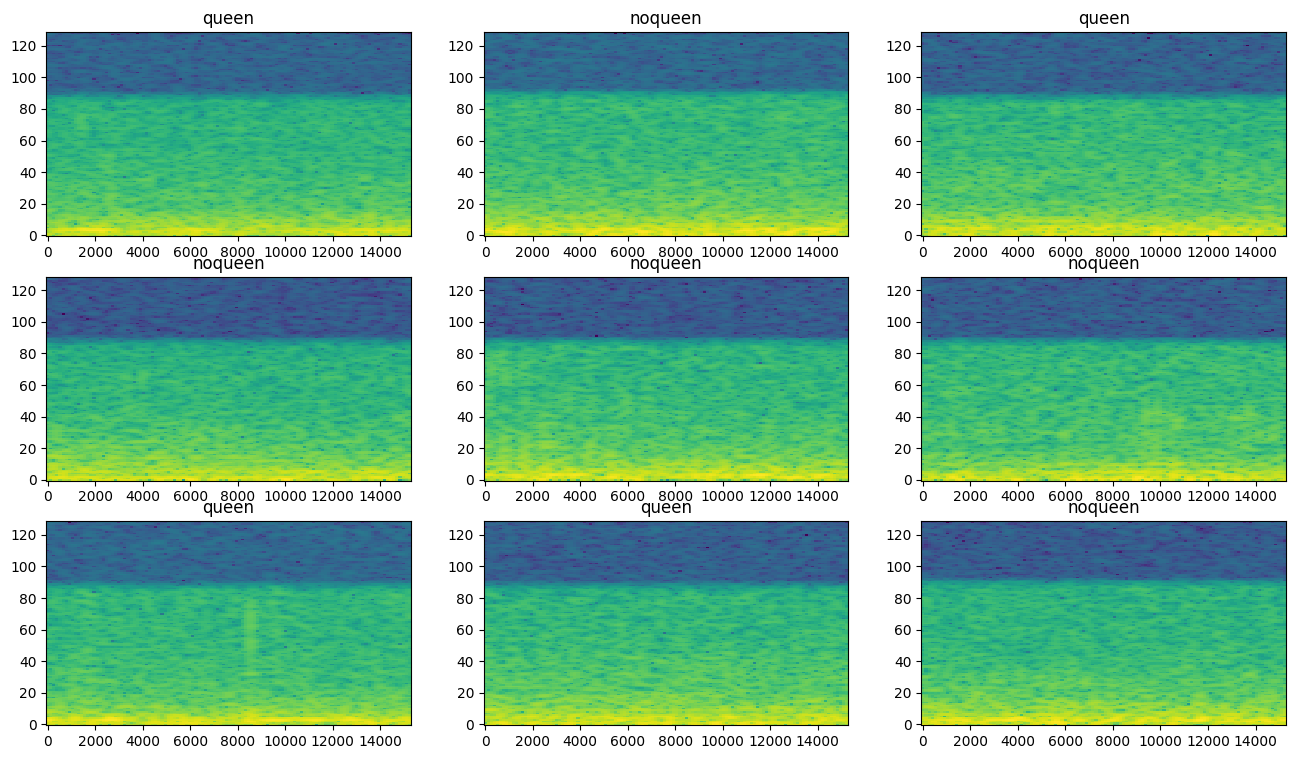

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
35/35 [==============================] - 2s 43ms/step - loss: 0.6951 - accuracy: 0.5238 - val_loss: 0.6693 - val_accuracy: 0.6071
Epoch 2/20
35/35 [==============================] - 1s 33ms/step - loss: 0.6456 - accuracy: 0.6190 - val_loss: 0.6543 - val_accuracy: 0.6548
Epoch 3/20
35/35 [==============================] - 1s 33ms/step - loss: 0.6159 - accuracy: 0.6548 - val_loss: 0.6624 - val_accuracy: 0.5958
Epoch 4/20
35/35 [==============================] - 1s 34ms/step - loss: 0.5868 - accuracy: 0.7143 - val_loss: 0.6459 - val_accuracy: 0.6494
Epoch 5/20
35/35 [==============================] - 1s 33ms/step - loss: 0.5653 - accuracy: 0.7119 - val_loss: 0.6432 - val_accuracy: 0.6595
Epoch 6/20
35/35 [==============================] - 1s 33ms/step - loss: 0.5441 - accuracy: 0.7095 - val_loss: 0.6537 - val_accuracy: 0.6417


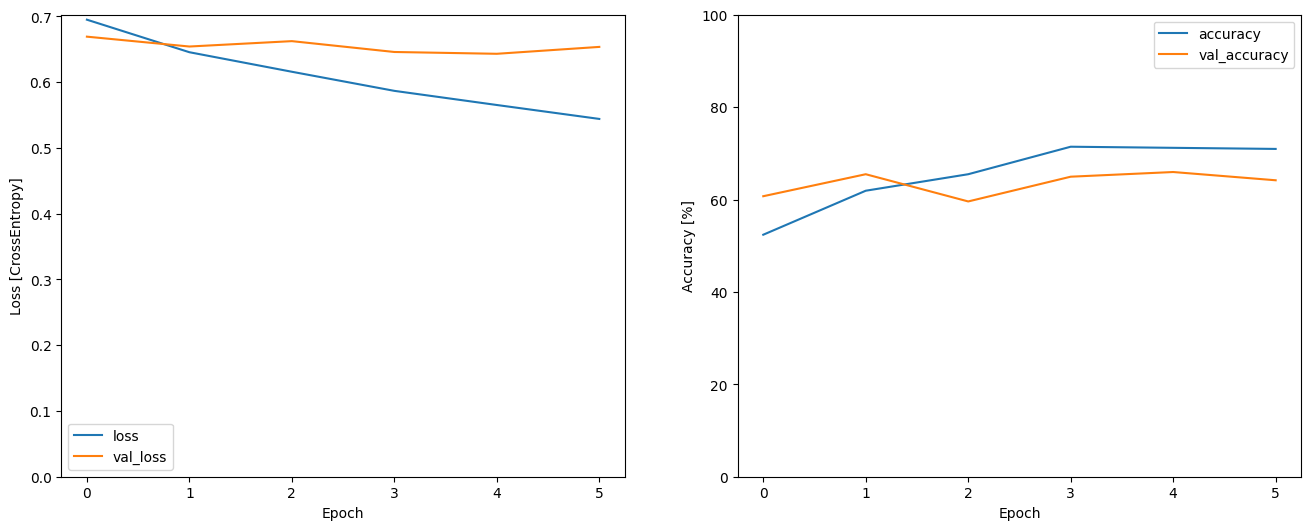

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
35/35 [==============================] - 1s 26ms/step - loss: 0.6875 - accuracy: 0.5214 - val_loss: 0.6751 - val_accuracy: 0.5048
Epoch 2/20
35/35 [==============================] - 1s 22ms/step - loss: 0.6493 - accuracy: 0.5976 - val_loss: 0.6607 - val_accuracy: 0.6113
Epoch 3/20
35/35 [==============================] - 1s 25ms/step - loss: 0.6125 - accuracy: 0.6857 - val_loss: 0.6510 - val_accuracy: 0.6339
Epoch 4/20
35/35 [==============================] - 1s 24ms/step - loss: 0.5901 - accuracy: 0.7143 - val_loss: 0.7047 - val_accuracy: 0.6554
Epoch 5/20
35/35 [==============================] - 1s 23ms/step - loss: 0.5742 - accuracy: 0.7024 - val_loss: 0.6574 - val_accuracy: 0.6405
Epoch 6/20
35/35 [==============================] - 1s 24ms/step - loss: 0.5633 - accuracy: 0.7238 - val_loss: 0.6657 - val_accuracy: 0.6518


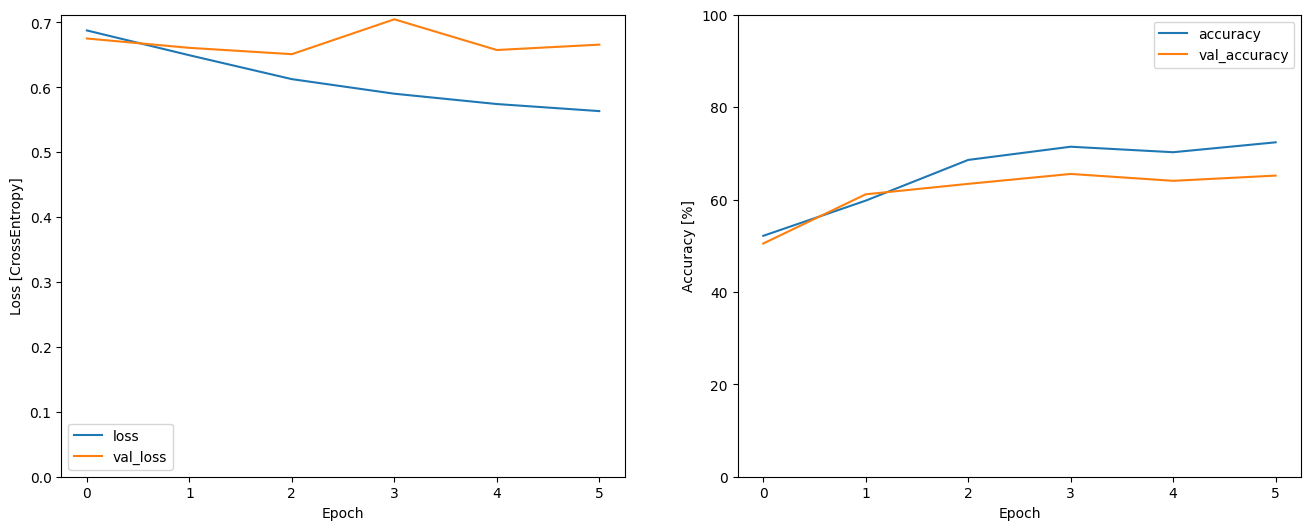

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

140/140 [==============================] - 1s 7ms/step - loss: 0.8877 - accuracy: 0.5458
MFCC Seq: [0.8877045512199402, 0.5458333492279053]
140/140 [==============================] - 1s 3ms/step - loss: 0.9187 - accuracy: 0.4964
MFCC Conv: [0.9186546206474304, 0.49642857909202576]
140/140 [==============================] - 1s 7ms/step - loss: 3.6884 - accuracy: 0.5018
Spec Seq: [3.6883809566497803, 0.5017856955528259]
140/140 [==============================] - 1s 4ms/step - loss: 10.6104 - accuracy: 0.4988
Spec Conv: [10.610366821289062, 0.4988095164299011]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
35/35 [==============================] - 1s 35ms/step - loss: 0.8336 - accuracy: 0.6143 - val_loss: 0.7564 - val_accuracy: 0.6512
Epoch 2/20
35/35 [==============================] - 1s 35ms/step - loss: 0.6171 - accuracy: 0.7381 - val_loss: 0.7311 - val_accuracy: 0.6375
Epoch 3/20
35/35 [==============================] - 1s 33ms/step - loss: 0.5697 - accuracy: 0.7500 - val_loss: 0.6908 - val_accuracy: 0.6512
Epoch 4/20
35/35 [==============================] - 1s 34ms/step - loss: 0.5360 - accuracy: 0.7524 - val_loss: 0.6747 - val_accuracy: 0.6476
Epoch 5/20
35/35 [==============================] - 1s 34ms/step - loss: 0.5184 - accuracy: 0.7714 - val_loss: 0.6543 - val_accuracy: 0.6661
Epoch 6/20
35/35 [==============================] - 1s 33ms/step - loss: 0.4937 - accuracy: 0.7833 - val_loss: 0.6684 - val_accuracy: 0.6524
Epoch 7/20
35/35 [==============================] - 1s 34ms/step - loss: 0.4830 - accuracy: 0.7881 - val_loss: 0.6633 - val_accuracy: 0.6571


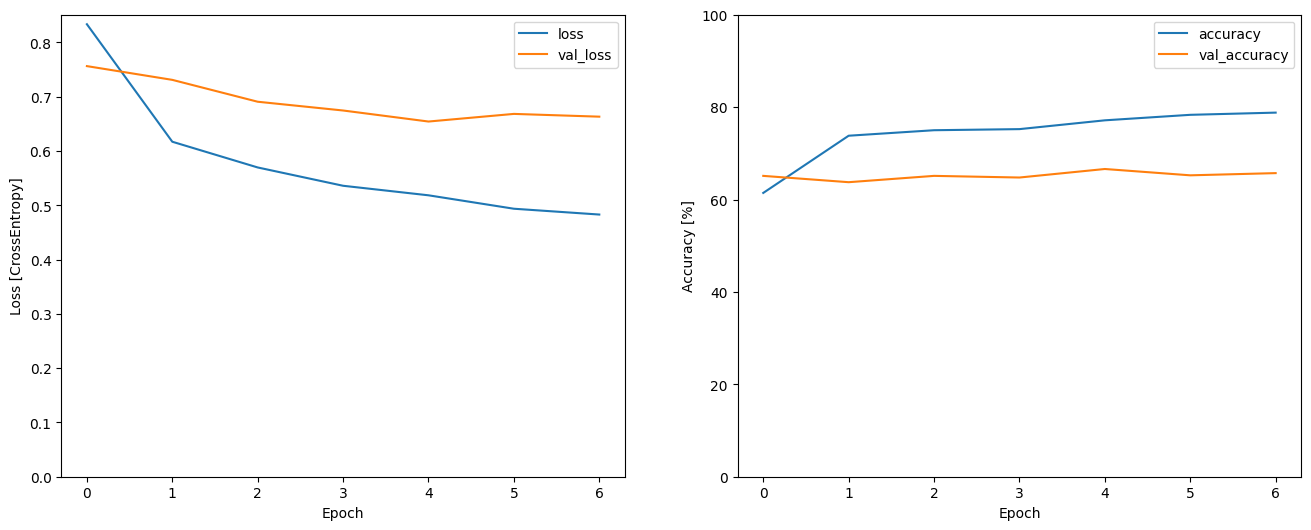

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20
35/35 [==============================] - 1s 16ms/step - loss: 0.7335 - accuracy: 0.5714 - val_loss: 0.6860 - val_accuracy: 0.6131
Epoch 2/20
35/35 [==============================] - 1s 16ms/step - loss: 0.6376 - accuracy: 0.6929 - val_loss: 0.6630 - val_accuracy: 0.6423
Epoch 3/20
35/35 [==============================] - 1s 15ms/step - loss: 0.5943 - accuracy: 0.6976 - val_loss: 0.6395 - val_accuracy: 0.6577
Epoch 4/20
35/35 [==============================] - 1s 15ms/step - loss: 0.5853 - accuracy: 0.7095 - val_loss: 0.6336 - val_accuracy: 0.6589
Epoch 5/20
35/35 [==============================] - 1s 16ms/step - loss: 0.5754 - accuracy: 0.7071 - val_loss: 0.6286 - val_accuracy: 0.6637
Epoch 6/20
35/35 [==============================] - 1s 15ms/step - loss: 0.5622 - accuracy: 0.7095 - val_loss: 0.6213 - val_accuracy: 0.6601


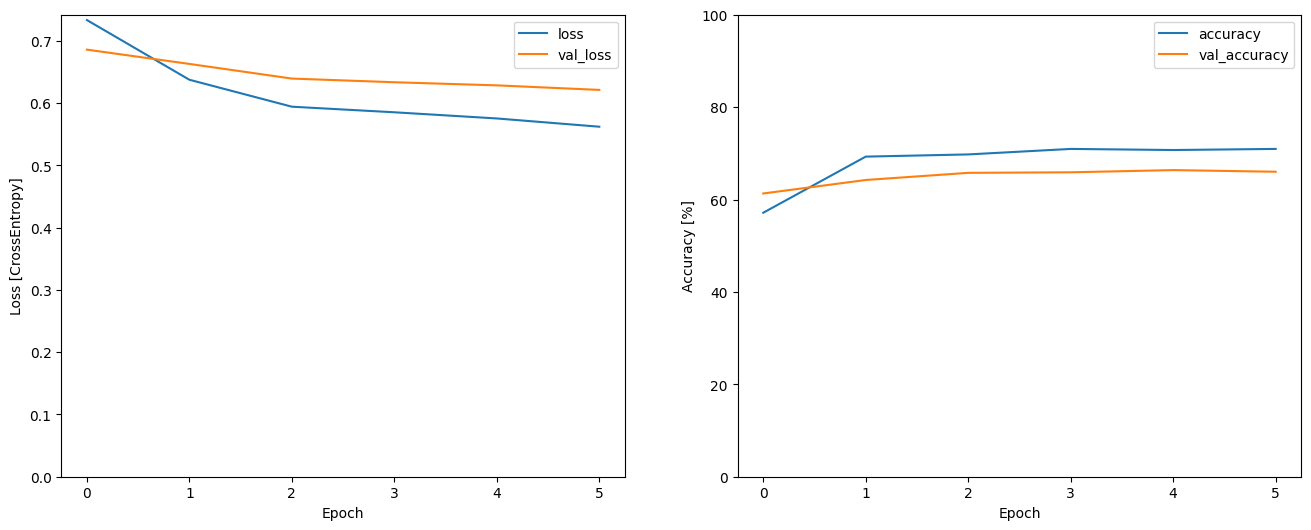

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
35/35 [==============================] - 1s 35ms/step - loss: 1.4248 - accuracy: 0.5452 - val_loss: 1.0267 - val_accuracy: 0.6161
Epoch 2/20
35/35 [==============================] - 1s 34ms/step - loss: 0.6316 - accuracy: 0.6643 - val_loss: 0.8179 - val_accuracy: 0.6298
Epoch 3/20
35/35 [==============================] - 1s 35ms/step - loss: 0.5910 - accuracy: 0.6952 - val_loss: 0.7353 - val_accuracy: 0.6381
Epoch 4/20
35/35 [==============================] - 1s 36ms/step - loss: 0.5673 - accuracy: 0.7119 - val_loss: 0.7717 - val_accuracy: 0.6357
Epoch 5/20
35/35 [==============================] - 1s 34ms/step - loss: 0.5438 - accuracy: 0.7095 - val_loss: 0.8279 - val_accuracy: 0.6244
Epoch 6/20
35/35 [==============================] - 1s 34ms/step - loss: 0.5180 - accuracy: 0.7405 - val_loss: 0.7615 - val_accuracy: 0.6345


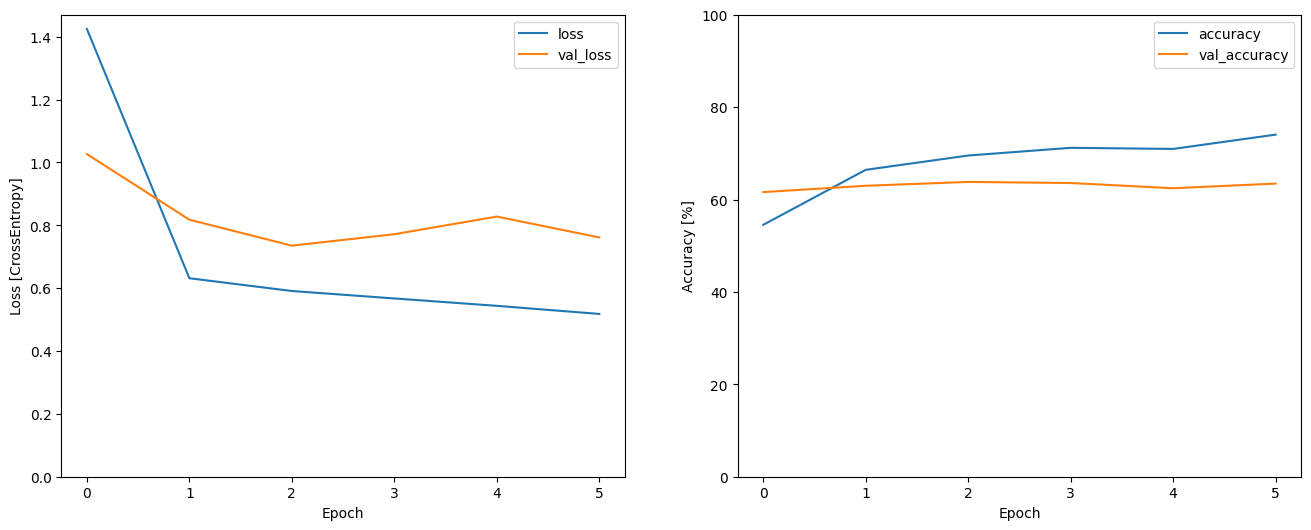

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20
35/35 [==============================] - 1s 19ms/step - loss: 3.4700 - accuracy: 0.5357 - val_loss: 3.1927 - val_accuracy: 0.5143
Epoch 2/20
35/35 [==============================] - 1s 17ms/step - loss: 1.7505 - accuracy: 0.5786 - val_loss: 1.7391 - val_accuracy: 0.5994
Epoch 3/20
35/35 [==============================] - 1s 17ms/step - loss: 1.0177 - accuracy: 0.6500 - val_loss: 1.3982 - val_accuracy: 0.6226
Epoch 4/20
35/35 [==============================] - 1s 17ms/step - loss: 0.8953 - accuracy: 0.6452 - val_loss: 1.3200 - val_accuracy: 0.6310
Epoch 5/20
35/35 [==============================] - 1s 17ms/step - loss: 0.8762 - accuracy: 0.6476 - val_loss: 1.3052 - val_accuracy: 0.6315
Epoch 6/20
35/35 [==============================] - 1s 18ms/step - loss: 0.8727 - accuracy: 0.6476 - val_loss: 1.2955 - val_accuracy: 0.6268
Epoch 7/20
35/35 [==============================] - 1s 18ms/step - loss: 0.8708 - accuracy: 0.6429 - val_loss: 1.2908 - val_accuracy: 0.6262


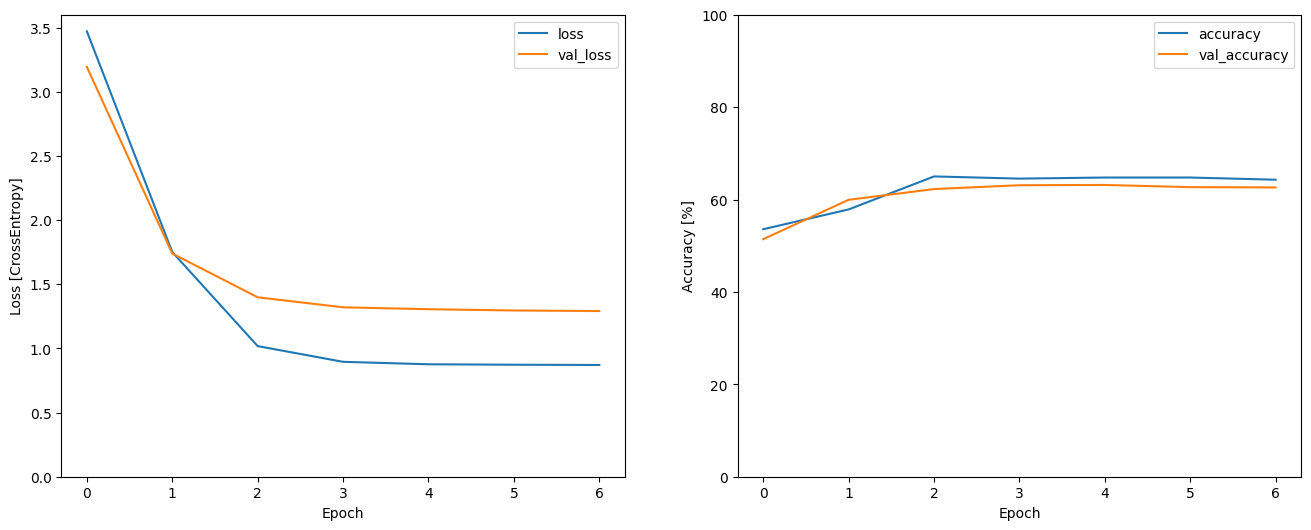

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Seq       :    Loss: 0.28, Acc: 0.89, VLoss: 0.60, VAcc: 0.70
MFCCs + Conv      :    Loss: 0.58, Acc: 0.72, VLoss: 0.63, VAcc: 0.66
Spectrogram + Seq :    Loss: 0.54, Acc: 0.71, VLoss: 0.65, VAcc: 0.64
Spectrogram + Conv:    Loss: 0.56, Acc: 0.72, VLoss: 0.67, VAcc: 0.65

=== TRAINED ===
Tr. MFCCs + Seq       :    Loss: 0.48, Acc: 0.79, VLoss: 0.66, VAcc: 0.66
Tr. MFCCs + Conv      :    Loss: 0.56, Acc: 0.71, VLoss: 0.62, VAcc: 0.66
Tr. Spectrogram + Seq :    Loss: 0.52, Acc: 0.74, VLoss: 0.76, VAcc: 0.63
Tr. Spectrogram + Conv:    Loss: 0.87, Acc: 0.64, VLoss: 1.29, VAcc: 0.63
